In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
DATASET_NAME = 'cifar'
DATASET_PATH = f'./data/{DATASET_NAME}'
OUT_DIR = f'tmp/{DATASET_NAME}'
FEATURES_PATH = f'./{OUT_DIR}/features'
GLM_PATH = f'./{OUT_DIR}/checkpoint'

ARCH = 'resnet50'
BATCH_SIZE = 128

#### Load data and loaders
---

In [21]:
from dataset import CIFAR
from robustness.model_utils import make_and_restore_model
from robustness.tools.label_maps import CLASS_DICT

dataset = CIFAR(DATASET_PATH)
dataset.label_mapping = CLASS_DICT['CIFAR']

model,_ = make_and_restore_model(arch = ARCH, dataset = dataset)
train_loader, val_loader = dataset.make_loaders(batch_size = BATCH_SIZE, 
                                                workers = os.cpu_count())

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


Setup a directory to output logs

In [4]:
import cox.store
from cox.utils import Parameters
from robustness import datasets, train, defaults

train_args = Parameters({
    'out_dir': "train_out",
    'adv_train': 1,
    'constraint': '2',
    'eps': 0.5,
    'attack_lr': 0.1,
    'attack_steps': 7,
    'epochs': 5
})

# Fill whatever parameters are missing from the defaults
train_args = defaults.check_and_fill_args(train_args,
                                          defaults.TRAINING_ARGS, 
                                          CIFAR)
train_args = defaults.check_and_fill_args(train_args,
                                          defaults.PGD_ARGS, 
                                          CIFAR)

/home/fabio/.local/lib/python3.7/site-packages/robustness/train.py:24: UserWarning: Could not import amp.
  warnings.warn('Could not import amp.')


#### Train the model
---

In [ ]:
train.train_model(train_args, 
                  model, 
                  (train_loader, val_loader), 
                  store = cox.store.Store('output'))
pass

#### Restore model
----

In [5]:
from utils import load_dataset

# model_path = os.path.join(out_store.path, 'checkpoint.pt.best')
model_path = "output/dc951e88-74cd-45b6-bfd2-80b59836acf6/checkpoint.pt.best"
dataset, train_loader, test_loader = load_dataset(dataset_name = DATASET_NAME,
                                                  dataset_path = DATASET_PATH,
                                                  batch_size = BATCH_SIZE,
                                                  num_workers = os.cpu_count(),
                                                  model_path = model_path)


==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [6]:
model, _ = make_and_restore_model(arch=ARCH, dataset=dataset, resume_path=model_path)
model.eval()
model.cuda()
pass

=> loading checkpoint 'output/dc951e88-74cd-45b6-bfd2-80b59836acf6/checkpoint.pt.best'
=> loaded checkpoint 'output/dc951e88-74cd-45b6-bfd2-80b59836acf6/checkpoint.pt.best' (epoch 16)


In [7]:
test_images, test_labels = [], []
for idx, (image, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
    test_images.append(image)
    test_labels.append(label)
    
test_images, test_labels = torch.cat(test_images), torch.cat(test_labels).numpy()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 104.22it/s]


#### Compute features
___

In [8]:
from feature_helpers import compute_features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_loaders, metadata = compute_features(model, 
                                             train_loader, 
                                             test_loader, 
                                             num_classes=dataset.num_classes,
                                             device=device,
                                             out_dir_feats=FEATURES_PATH)

--------- Computing/loading deep features ---------
For train set...
==> loaded 3 files of representations...
For test set...
==> loaded 1 files of representations...


#### Calculate the regularization path
---
A path algorithm for the elastic net calculates the regularization path where sparsity ranges the entire spectrum from the trivial zero model (β = 0) to completely dense. This regularization path can then be used to select a single linear model to satisfy application-specific sparsity or accuracy thresholds (as measured on a validation set). In addition, these paths can be used to visualize the evolution of weights assigned to specific features as a function of sparsity constraints on the model, thereby providing further insight into the relative importance of features.

In [9]:
num_classes = dataset.num_classes
num_features = metadata["X"]["num_features"][0]

linear = nn.Linear(num_features, num_classes).to(device)
for p in [linear.weight, linear.bias]: 
    p.data.zero_()

In [10]:
from dataset import NormalizedRepresentation

preprocess = NormalizedRepresentation(feature_loaders['train'], 
                                      metadata=metadata, 
                                      device=linear.weight.device)

The elastic net yields a sequence of linear models—with varying accuracy and sparsity — also known as the regularization path. 

In [ ]:
from glm_saga.elasticnet import glm_saga 

params = glm_saga(linear, 
                 feature_loaders['train'], 
                 max_lr = 0.1, 
                 nepochs = 2000, 
                 alpha = 0.99, 
                 val_loader=feature_loaders['val'],
                 test_loader=feature_loaders['test'],
                 n_classes=num_classes, 
                 checkpoint=GLM_PATH,
                 verbose = 2000, 
                 tol=1e-4, 
                 lookbehind=3, 
                 lr_decay_factor=1,
                 group=True, 
                 epsilon=0.001, 
                 metadata=metadata,
                 preprocess=preprocess)

#### Load pre-computed deep features
___

In [ ]:
from feature_helpers import load_features_mode

features, feature_mean, feature_std = load_features_mode(FEATURES_PATH, 
                                                         mode='test',
                                                         batch_size=BATCH_SIZE,
                                                         num_workers=os.cpu_count())

In [18]:
maximal_idx = np.argmax(features, axis=0)

#### Load regularization path
___

In [11]:
from utils import load_glm
glm_res = load_glm(GLM_PATH)

Loading regularization path of length 101


#### Visualize sparsity-accuracy tradeoff
___

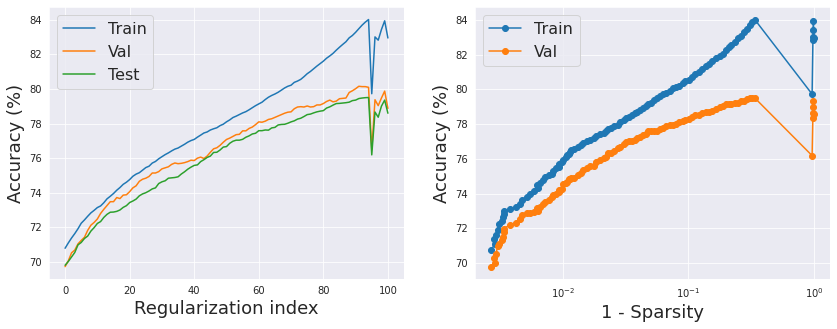

In [36]:
from utils import plot_sparsity
plot_sparsity(glm_res)

In [30]:
nf = glm_res['weights'][0].shape[1]
tt = np.mean(glm_res['sparsity'], axis=1) / nf
tt.shape

(101,)

Sparsity vs. accuracy trade-offs of sparse decision layers. Each point on the curve corresponds to single linear classifier from the regularization path.

#### Select a single sparse model
___

In [13]:
from utils import select_sparse_model

CRITERION = 'absolute'
FACTOR = 5

glm_res = select_sparse_model(glm_res,
                              selection_criterion=CRITERION,
                              factor=FACTOR)

Test accuracy | Best:  79.51, Sparse: 74.22 Sparsity: 18.90


#### Feature visualization
---
We can now compare the deep features used by the dense and sparse decision layers for a set of randomly chosen classes. 
Note that the feature interpretations (feature visualization and LIME) are constructed accounting for the sign of the weight assigned to a deep feature. In other words, if the weight assigned to a deep feature is positive (negative), the feature interpretation presented below denotes input patterns that are cause the feature to be most positive (negative).

In [19]:
Nclasses = glm_res['weight_sparse'].shape[0]
Nplot = 5
Nfeatures = 5
FEATURE_SEL = 'rand'
MODE = 'pos' # Visualize top-k weights in actual value ('pos') or magnitude ('all')
WT_THRESH = 1e-3 # Ignore very small weights

rng = np.random.RandomState(0)


---Class: cat---


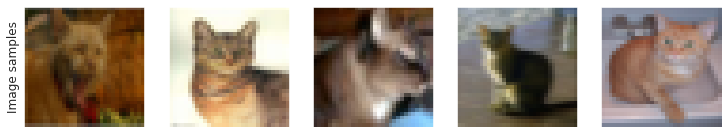

--Dense model--
Number of features used for this class: 724


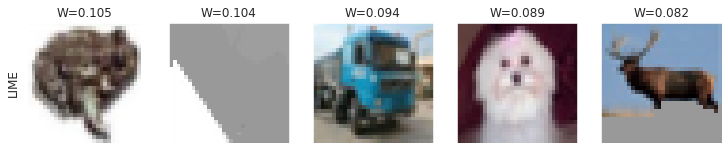

--Sparse model--
Number of features used for this class: 14


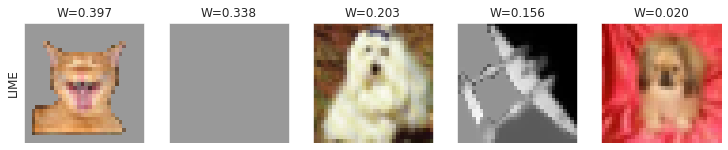


---Class: ship---


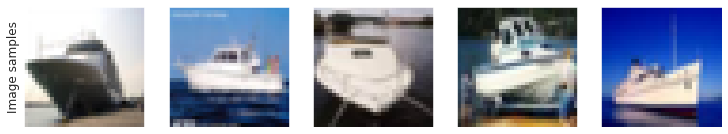

--Dense model--
Number of features used for this class: 427


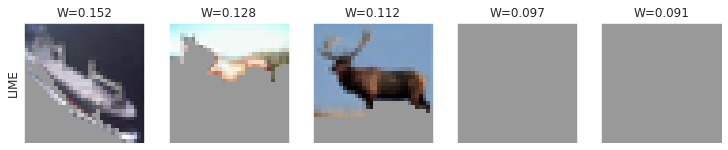

--Sparse model--
Number of features used for this class: 14


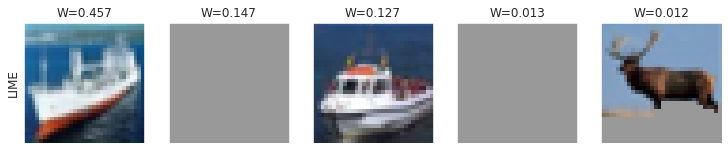


---Class: cat---


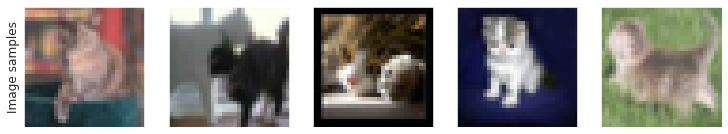

--Dense model--
Number of features used for this class: 724


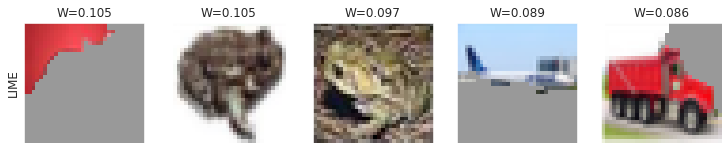

--Sparse model--
Number of features used for this class: 14


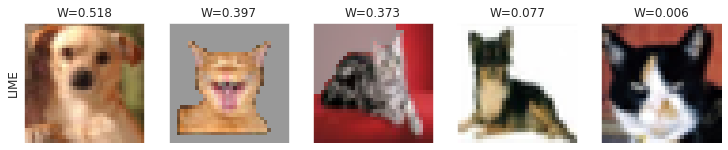


---Class: cat---


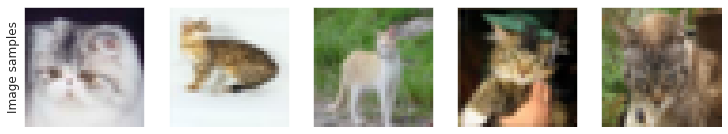

--Dense model--
Number of features used for this class: 724


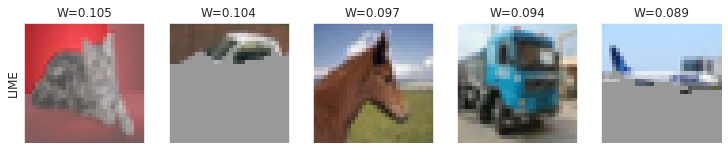

--Sparse model--
Number of features used for this class: 14


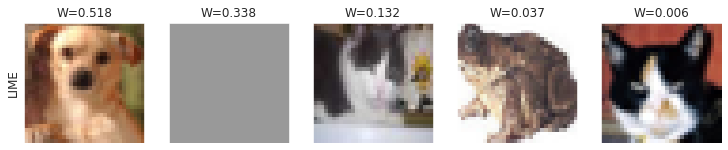


---Class: dog---


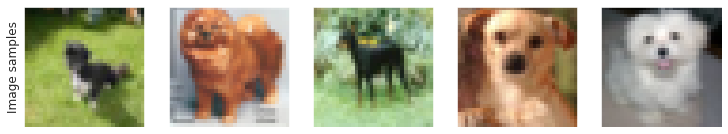

--Dense model--
Number of features used for this class: 694


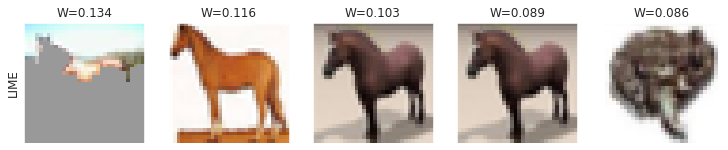

--Sparse model--
Number of features used for this class: 19


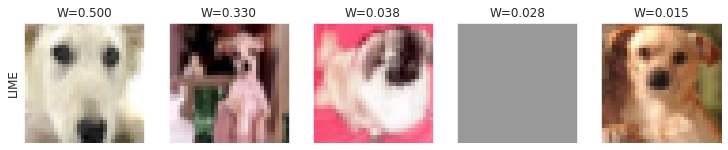

In [22]:
from lucent.optvis import render, param, transform, objectives
from utils import get_lime_explanation, show_image_row

for pi in range(Nplot):
    pc = rng.choice(Nclasses, 1)[0]
    feature_indices, signs, weights, Nfs = [], [], [], []

    for weight_type in ['sparse', 'dense']:
        
        # Find top-k features, where k=#features used by sparse model
        weight_class = glm_res[f'weight_{weight_type}'][pc]
        weight_class = weight_class.numpy() / np.linalg.norm(weight_class.numpy())

        if MODE == 'all':
            rel_idx = np.where(np.abs(weight_class) > WT_THRESH)[0]
        else:
            rel_idx = np.where(weight_class > WT_THRESH)[0]

        if weight_type == 'sparse':
            Nf = len(rel_idx)

        if MODE == 'all':
            largest_features = rel_idx[np.argsort(-np.abs(weight_class[rel_idx]))]
        else:
            largest_features = rel_idx[np.argsort(-weight_class[rel_idx])]

        # Plot Nplot randomly-chosen ones
        feature_idx = rng.choice(largest_features[:Nf], Nfeatures, replace=False)        
        feature_idx = feature_idx[np.argsort(-weight_class[feature_idx])]

        for x, y in zip([feature_indices, signs, weights, Nfs],
                        [feature_idx, np.sign(weight_class[feature_idx]), 
                         weight_class[feature_idx], len(rel_idx)]):
            x.append(y)

    feature_indices, signs = np.concatenate(feature_indices), np.concatenate(signs)
    img_indices = maximal_idx[feature_indices]
    
    # Lime explanation
    lime_exp = get_lime_explanation(model, 
                                   feature_indices,
                                   signs,
                                   test_images[img_indices].double(), 
                                   feature_mean, feature_std,
                                   NLime=10,
                                   background_color=0.6)
    
    print(f"---Class: {dataset.label_mapping[pc]}---")
    class_idx = rng.choice(np.where(test_labels == pc)[0], Nfeatures, replace=False)
    show_image_row([test_images[class_idx]], 
                       ['Image samples']) 

    for idx, model_type, Nf in zip([np.arange(Nfeatures,2*Nfeatures), np.arange(Nfeatures)],
                                   ['Dense', 'Sparse'],
                                   Nfs[::-1]):

        print(f'--{model_type} model--')
        print(f'Number of features used for this class: {Nf}')
        show_image_row([lime_exp[idx]], ['LIME'],
                       tlist=[[f"W={w:.3f}" for w in np.concatenate(weights)[idx]]])
